<h1><center> Visual Speech Recognition || Yael Sasson </center></h1>

## 📦 Importing Libraries

In [1]:
#!pip install numpy==1.26.4
#!pip install --upgrade evaluate jiwer
#!pip instal==gdown

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
import json

In [3]:
url = 'https://drive.google.com/uc?id=19NUAFO99WPGjw-884CMLMc9XOlLo6LE5'
output = 'ml_project.zip'
gdown.download(url, output, quiet=True)
gdown.extractall('ml_project.zip')

['ml_project/',
 'ml_project/align/',
 'ml_project/align/bbaf2n.align',
 'ml_project/align/bbaf3s.align',
 'ml_project/align/bbaf4p.align',
 'ml_project/align/bbaf5a.align',
 'ml_project/align/bbal6n.align',
 'ml_project/align/bbal7s.align',
 'ml_project/align/bbal8p.align',
 'ml_project/align/bbal9a.align',
 'ml_project/align/bbas1s.align',
 'ml_project/align/bbas2p.align',
 'ml_project/align/bbas3a.align',
 'ml_project/align/bbaszn.align',
 'ml_project/align/bbaz4n.align',
 'ml_project/align/bbaz5s.align',
 'ml_project/align/bbaz6p.align',
 'ml_project/align/bbaz7a.align',
 'ml_project/align/bbbf6n.align',
 'ml_project/align/bbbf7s.align',
 'ml_project/align/bbbf8p.align',
 'ml_project/align/bbbf9a.align',
 'ml_project/align/bbbm1s.align',
 'ml_project/align/bbbm2p.align',
 'ml_project/align/bbbm3a.align',
 'ml_project/align/bbbmzn.align',
 'ml_project/align/bbbs4n.align',
 'ml_project/align/bbbs5s.align',
 'ml_project/align/bbbs6p.align',
 'ml_project/align/bbbs7a.align',
 'ml_proje

In [4]:
vocab = list("abcdefghijklmnopqrstuvwxyz'?!123456789 ")

In [5]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print("The vocabulary is:", char_to_num.get_vocabulary())
print("size:", char_to_num.vocabulary_size())


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
size: 40


In [6]:
def extract_alignment(align_path):
    with open(align_path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] not in ['sil', 'sp']:
          tokens = [*tokens,' ',line[2]]

    # Convert to TensorFlow Tensor
    token_tensor = tf.strings.unicode_split(tokens, input_encoding='UTF-8')
    return char_to_num(tf.reshape(token_tensor, (-1)))[1:]  # Remove the first element (always 'sil')

In [7]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    frames_path = os.path.join('ml_project','model','processed_new70X40', f'{file_name}.npy')


    frames = tf.convert_to_tensor(np.load(frames_path), dtype=tf.float32)

    # Load alignment
    alignment_path = os.path.join('ml_project','model','align_new',f'{file_name}.align')
    alignments =  extract_alignment(alignment_path)

    return frames, alignments


##🗄️Data Pipeline

In [8]:
def mappable_function(path):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [9]:
data = tf.data.Dataset.list_files('/content/ml_project/model/align_new/*.align')
data = data.shuffle(3000, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None, None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(2700)
test = data.skip(2700)

In [ ]:
# Create directories for saving datasets
save_dir = './saved_datasets'
os.makedirs(save_dir, exist_ok=True)

train.save(os.path.join(save_dir, 'train'))
test.save(os.path.join(save_dir, 'test'))

In [ ]:
import shutil

# Create a ZIP archive of saved datasets
shutil.make_archive('saved_datasets', 'zip', 'saved_datasets')

'/content/saved_datasets.zip'

<tf.Tensor: shape=(), dtype=string, numpy=b'set white with i five please'>

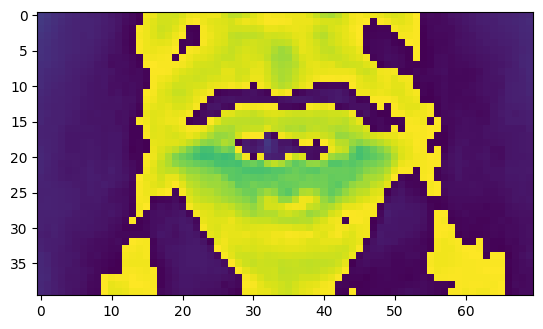

In [10]:
sample = data.as_numpy_iterator()
val = sample.next(); val[0]
plt.imshow(val[0][0][35])
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

## 🛠️ Model Building

<div dir="rtl">

מייבא את הספריות הנדרשות לבניית המודל

</div>


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv3D, Dense, Dropout, Bidirectional,
                                     MaxPool3D, Activation, Reshape, SpatialDropout3D,
                                     BatchNormalization, TimeDistributed, Flatten,
                                     GlobalAveragePooling3D, GRU)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

<div dir="rtl">
המימדים עבור סרטון יחיד
</div>

In [12]:
input_shape = data.as_numpy_iterator().next()[0][0].shape

In [13]:
print(input_shape)

(75, 40, 70, 1)


<div dir="rtl">

ארכיטקטורת המודל שלי
</div>


In [ ]:
model = Sequential()
model.add(Conv3D(128, (3, 3, 3), input_shape=input_shape , padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Reshape((75, -1)))
model.add(Bidirectional(GRU(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(GRU(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 40, 70,     │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 40, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 20, 35,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 20, 35,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 20, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 10, 17,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 10, 17, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 10, 17, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 8, 75)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 75, 3000)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     2,403,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,117,876 (15.71 MB)

 Trainable params: 4,117,876 (15.71 MB)

 Non-trainable params: 0 (0.00 B)

## ⭐ Setup Training Options

<div dir="rtl">

הגדרת פונקציית ההפסד

</div>


In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")  # Batch size
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")  # Length of the input sequence (number of frames)
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")  # Length of the target sequence (number of characters)

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")  # Expand input length for each sample in the batch
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")  # Expand label length for each sample in the batch

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)  # Compute the CTC loss
    return loss  # Return the loss value


<div dir="rtl">

מגדירה  Callback שמדפיסה דוגמאות מקוריות וניבוי של המודל בסוף כל אפוק.  

</div>


In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None):
        data = self.dataset.next()
        yhat = self.model.predict(data[0])  # Predict the output based on the input frames

        # Decode predictions using CTC decoding (beam search)
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

        # Print original and predicted text for each example in the batch
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)


<div dir="rtl">

קומפילציה של המודל עם האופטימיזטור `Adam` ופונקציית ההפסד `CTCLoss`.  
האופטימיזטור `Adam` משתמש בקצב למידה של **0.0001**

</div>


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


## 🚀 Model Training

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
local_path = "/content/model.keras"

model_save = ModelCheckpoint(
    local_path,
    monitor='val_loss',
    save_best_only=True,  # Save only if the model improves
    save_weights_only=False,  # Save the entire model (not just weights)
    verbose=1
)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[model_save, example_callback, early_stopping ])

Epoch 1/100
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 79.6740
Epoch 1: val_loss improved from inf to 59.10464, saving model to /content/model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
Original: bin blue with q seven soon
Prediction: la e e e oeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white in m three again
Prediction: la e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 799s 292ms/step - loss: 79.6708 - val_loss: 59.1046
Epoch 2/100
2700/2700 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 59.6530
Epoch 2: val_loss improved from 59.10464 to 48.31960, saving model to /content/model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Original: lay white by z one please
Prediction: la he i e ae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue with f five

<div dir="rtl">

שמירת ההיסטוריה בקובץ json

</div>


In [ ]:
import json
with open('historyModel.json', 'w') as f:
    json.dump(model.history.history, f)

In [ ]:
from google.colab import files

files.download("/content/model.keras")
files.download('historyModel.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##val

In [ ]:
def load_val_data(path):
  path = bytes.decode(path.numpy())
  file_name = path.split('/')[-1].split('.')[0]
  frames_path = os.path.join('ml_project','preVal','val_70x40', f'{file_name}.npy')
  frames = tf.convert_to_tensor(np.load(frames_path), dtype=tf.float32)
  alignment_path = os.path.join('ml_project','preVal', 'align', f'{file_name}.align')
  alignments = extract_alignment(alignment_path)
  return frames, alignments



    # Create mappable function for validation data

def val_mappable_function(path):
  result = tf.py_function(load_val_data, [path], (tf.float32, tf.int64))
  return result



    # Create validation dataset
val_data = tf.data.Dataset.list_files('./ml_project/preVal/align/*.align')
val_data = val_data.map(val_mappable_function)
val_data = val_data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
val_data = val_data.prefetch(tf.data.AUTOTUNE)


In [ ]:
train = tf.data.Dataset.load('/content/ml_project/model/train')
test = tf.data.Dataset.load('/content/ml_project/model/test')

##🔍 Evaluation

In [ ]:
import json
with open('/content/ml_project/model/historyModel.json', 'r') as f:
    historyModel = json.load(f)


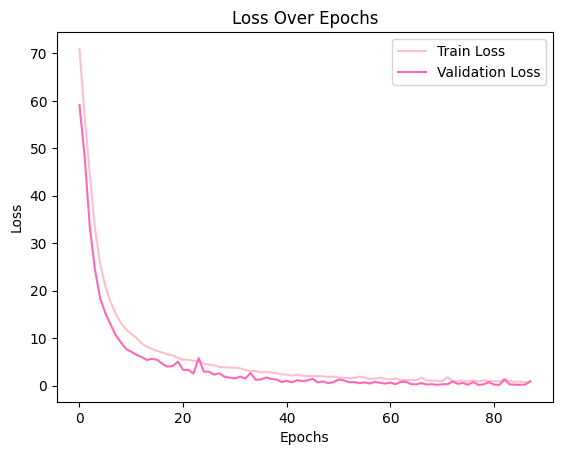

In [ ]:
import matplotlib.pyplot as plt

plt.plot(historyModel['loss'], label='Train Loss', color='pink')
plt.plot(historyModel['val_loss'], label='Validation Loss', color='hotpink')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/ml_project/model/model.keras', compile=True, custom_objects={'CTCLoss': CTCLoss})


In [ ]:
from evaluate import load

# Load HuggingFace metrics once
wer_metric = load("wer")
cer_metric = load("cer")

def predict_from_video(model, video_tensor):
    yhat = model.predict(video_tensor, verbose=0)
    batch_size = yhat.shape[0]
    input_lengths = tf.constant([yhat.shape[1]] * batch_size)

    decoded, _ = tf.keras.backend.ctc_decode(yhat, input_length=input_lengths, greedy=True)
    decoded_sequences = decoded[0]

    results = []
    for seq in decoded_sequences:
        seq = tf.convert_to_tensor(seq)
        text = tf.strings.reduce_join(num_to_char(seq)).numpy().decode("utf-8")
        results.append(text)

    return results


def evaluate_wer_cer(model, dataset, max_batches=None, name=""):
    references = []
    predictions = []

    for i, batch in enumerate(dataset):


        x, y_true = batch
        y_preds = predict_from_video(model, x)

        for j in range(len(y_preds)):
            ref = tf.strings.reduce_join(num_to_char(y_true[j])).numpy().decode("utf-8")
            pred = y_preds[j]

            predictions.append(pred)
            references.append(ref)

    wer = wer_metric.compute(references=references, predictions=predictions)
    cer = cer_metric.compute(references=references, predictions=predictions)

    print(f"{name} Set:")
    print(f"WER: {wer:.2%}")
    print(f"CER: {cer:.2%}")
    return wer, cer


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
evaluate_wer_cer(model, train, num_to_char, name="Train on model")
evaluate_wer_cer(model, test, num_to_char, name="Test on model")
evaluate_wer_cer(model, val_data, num_to_char, name="Validation on model")

Train on model Set:
WER: 0.06%
CER: 0.02%
Test on model Set:
WER: 0.11%
CER: 0.04%
Validation on model Set:
WER: 55.80%
CER: 36.32%


(0.558, 0.3631553437272801)

##continue training

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/ml_project/model/model.keras', compile=True, custom_objects={'CTCLoss': CTCLoss})



In [ ]:
url = 'https://drive.google.com/uc?id=10kOqbu1CZSDKxXFa-B-oR5cOEbFrRyUt'
output = 'align2.zip'
gdown.download(url, output, quiet=True)
gdown.extractall('align2.zip')

['align/',
 'align/bbab8n.align',
 'align/bbab9s.align',
 'align/bbac1a.align',
 'align/bbaczp.align',
 'align/bbae4n.align',
 'align/bbae5n.align',
 'align/bbae5s.align',
 'align/bbae6n.align',
 'align/bbae6p.align',
 'align/bbae6s.align',
 'align/bbae7a.align',
 'align/bbae7p.align',
 'align/bbae7s.align',
 'align/bbae8a.align',
 'align/bbae8p.align',
 'align/bbae9a.align',
 'align/bbai2n.align',
 'align/bbai3s.align',
 'align/bbai4p.align',
 'align/bbai5a.align',
 'align/bbak8n.align',
 'align/bbak9n.align',
 'align/bbak9s.align',
 'align/bbal1a.align',
 'align/bbal1p.align',
 'align/bbal1s.align',
 'align/bbal2a.align',
 'align/bbal2p.align',
 'align/bbal3a.align',
 'align/bbalzn.align',
 'align/bbalzp.align',
 'align/bbalzs.align',
 'align/bbao6n.align',
 'align/bbao7s.align',
 'align/bbao8p.align',
 'align/bbao9a.align',
 'align/bbar2n.align',
 'align/bbar3n.align',
 'align/bbar3s.align',
 'align/bbar4n.align',
 'align/bbar4p.align',
 'align/bbar4s.align',
 'align/bbar5a.align',


In [ ]:
url = 'https://drive.google.com/uc?id=1LG4qPXlWn_1qJTyPcTQO0blriHZbehJd'
output = 'data2.zip'
gdown.download(url, output, quiet=True)
gdown.extractall('data2.zip')

['data2_70x40/',
 'data2_70x40/lgie2n.npy',
 'data2_70x40/bbii1a.npy',
 'data2_70x40/sray5a.npy',
 'data2_70x40/pgip7s.npy',
 'data2_70x40/lrbe3a.npy',
 'data2_70x40/sgwi7n.npy',
 'data2_70x40/lrix4s.npy',
 'data2_70x40/sgwv4n.npy',
 'data2_70x40/lrwvzp.npy',
 'data2_70x40/pwac5n.npy',
 'data2_70x40/brir4n.npy',
 'data2_70x40/lrax6n.npy',
 'data2_70x40/sgwi9s.npy',
 'data2_70x40/sgbv1n.npy',
 'data2_70x40/srag8s.npy',
 'data2_70x40/sbbg8a.npy',
 'data2_70x40/swaa9n.npy',
 'data2_70x40/sgab6n.npy',
 'data2_70x40/bbwl9a.npy',
 'data2_70x40/srwh6p.npy',
 'data2_70x40/pgag9s.npy',
 'data2_70x40/sgwm4n.npy',
 'data2_70x40/bgis9p.npy',
 'data2_70x40/bbirzs.npy',
 'data2_70x40/lgwm1s.npy',
 'data2_70x40/pwii5s.npy',
 'data2_70x40/pgbq6a.npy',
 'data2_70x40/bgatzn.npy',
 'data2_70x40/sgwc5p.npy',
 'data2_70x40/sgaf5a.npy',
 'data2_70x40/lrby4p.npy',
 'data2_70x40/bwad1s.npy',
 'data2_70x40/bgwh1s.npy',
 'data2_70x40/prwt3s.npy',
 'data2_70x40/sgai2a.npy',
 'data2_70x40/srig5p.npy',
 'data2_70x

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    frames_path = os.path.join('data2_70x40', f'{file_name}.npy')


    frames = tf.convert_to_tensor(np.load(frames_path), dtype=tf.float32)

    # Load alignment
    alignment_path = os.path.join('align',f'{file_name}.align')
    alignments =  extract_alignment(alignment_path)

    return frames, alignments


In [ ]:
def mappable_function(path):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [ ]:
data = tf.data.Dataset.list_files('align/*.align')
data = data.shuffle(2000, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None, None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(1800)
test = data.skip(1800)

In [ ]:
# Create directories for saving datasets
save_dir = './saved_datasets2'
os.makedirs(save_dir, exist_ok=True)

train.save(os.path.join(save_dir, 'train'))
test.save(os.path.join(save_dir, 'test'))

In [ ]:
import shutil

# Create a ZIP archive of saved datasets
shutil.make_archive('saved_datasets2', 'zip', 'saved_datasets2')

'/content/saved_datasets2.zip'

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
model_save = ModelCheckpoint(
    filepath="/content/model_v2.keras",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[model_save, example_callback, early_stopping ])

Epoch 1/100
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 49.3688
Epoch 1: val_loss improved from inf to 12.61385, saving model to /content/model_v2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
Original: set white by b seven again
Prediction: set white by b seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue in u four please
Prediction: place blue at u four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 509s 279ms/step - loss: 49.3603 - val_loss: 12.6138
Epoch 2/100
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 17.1318
Epoch 2: val_loss improved from 12.61385 to 8.53451, saving model to /content/model_v2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Original: place red at o nine again
Prediction: place ren it j thine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
from google.colab import files
files.download("/content/model_v2.keras")

In [ ]:
!unzip -q /content/saved_datasets2.zip

In [ ]:
train = tf.data.Dataset.load('/content/train')
test = tf.data.Dataset.load('/content/test')

In [ ]:
evaluate_wer_cer(model, train, num_to_char, name="Train on model")
evaluate_wer_cer(model, test, num_to_char, name="Test on model")
evaluate_wer_cer(model, val_data, num_to_char, name="Validation on model")

Train on model Set:
WER: 2.37%
CER: 1.28%
Test on model Set:
WER: 2.54%
CER: 1.37%
Validation on model Set:
WER: 48.15%
CER: 29.33%


(0.4815, 0.2932789401405606)